In [1]:
import itertools
import os, sys
import numpy as np

from datetime import datetime, date

In [2]:
import pandas as pd

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [5]:
import sklearn as sk
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# Time Series Modelling

In statistics and quantitative research methodology, a *sample* is a set of individuals or objects collected or selected from a statistical population by a defined procedure.

In mathematical terms, given a probability distribution F, a random sample of length n (where n may be any positive integer) is a set of realizations of n *independent, identically distributed (iid) random variables with distribution F*.

In `cross-sectional` data analysis, it is commonly assumed that observations in a sample are effectively  i.i.d.

What about in `time-series analysis`?

For time series:
* independence is not evident at all due to temporal ordering
* identically distributed is a very strong statement leading to *strong stationarity* (the distribution properties of blue dots and red dots below must not be the same)
* randomness is understood in a way that the given time series is a realized path of discrete stochastic process.

*Simple stochastic process: random walk in time*

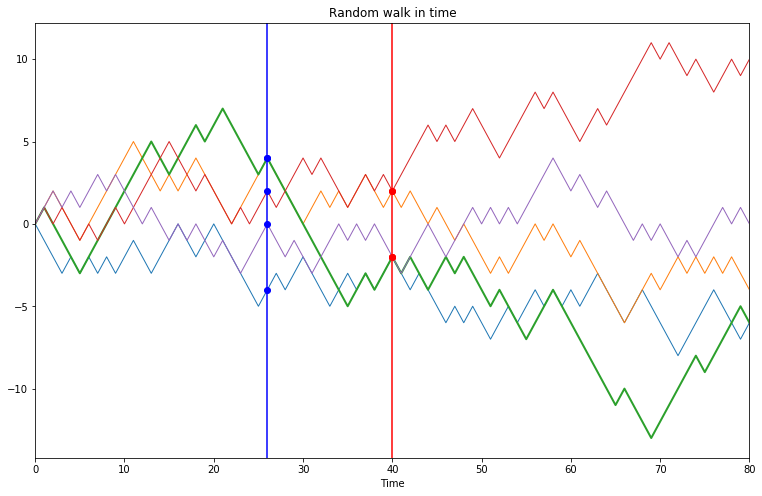

In [8]:
N=5
paths = []
for i in range(N):
    dims = 1
    step_n = 80
    step_set = [-1, 1]
    origin = np.zeros((1,dims))
    step_shape = (step_n,dims)
    steps = np.random.choice(a=step_set, size=step_shape)
    path = np.concatenate([origin, steps]).cumsum(0)
    start = path[:1]
    stop = path[-1:]
    paths.append(path)

fig = plt.figure(figsize=(8*1.6,8))
ax = fig.add_subplot(111)

k = int(step_n/2)
l = int(step_n/3)
for i in range(len(paths)):
    if i == 2:
        ax.plot(paths[i],lw=2)
    else:
        ax.plot(paths[i],lw=1)
    ax.set_xlim(0, step_n)
    ax.plot(k, paths[i][k], c='red', marker='o')
    ax.plot(l, paths[i][l], c='blue', marker='o')
    
ax.set_xlabel('Time')
ax.set_title('Random walk in time')
plt.axvline(k, color='r')
plt.axvline(l, color='b')
plt.show()

# Modelling framework

* data retrieval
* visualisations
* data transformations
* stationarity
* training | validation | testing data-set splits
* initial model selection
* forecasting
* model performance metrics
* cross-validation error
* final model selection (can be based subsequently based on CV error above) 

# Data

In [9]:
df_google = pd.read_csv('google.csv'); df_google.head()

day ticker   name  ccy   indx         open         high  \
0  2021-01-05  GOOGL  GOOGL  USD  SP500  1725.089966  1746.829956   
1  2021-01-04  GOOGL  GOOGL  USD  SP500  1760.000000  1762.489990   
2  2020-12-31  GOOGL  GOOGL  USD  SP500  1737.270020  1757.500000   
3  2020-12-30  GOOGL  GOOGL  USD  SP500  1765.000000  1767.760010   
4  2020-12-29  GOOGL  GOOGL  USD  SP500  1787.229980  1788.469971   

           low        close     volume   closeunadj  
0  1716.900024  1740.050049  1015942.0  1740.050049  
1  1707.140015  1726.130005  1866195.0  1726.130005  
2  1736.089966  1752.640015  1053479.0  1752.640015  
3  1728.000000  1736.250000  1051308.0  1736.250000  
4  1755.109985  1757.760010   982077.0  1757.760010

# Exploratory Analysis

In [12]:
# we see that day is 'object' - we need to convert to datetime
df_google.dtypes.to_frame()

0
day         datetime64[ns]
ticker              object
name                object
ccy                 object
indx                object
open               float64
high               float64
low                float64
close              float64
volume             float64
closeunadj         float64

**`pd.to_datetime()`**

In [13]:
df_google['day'] = pd.to_datetime(df_google['day'])

df_google.head(1)

day ticker   name  ccy   indx         open         high          low  \
0 2021-01-05  GOOGL  GOOGL  USD  SP500  1725.089966  1746.829956  1716.900024   

         close     volume   closeunadj  
0  1740.050049  1015942.0  1740.050049

**`describe()`**

In [14]:
df_google.describe()

open         high          low        close        volume  \
count  4124.000000  4124.000000  4124.000000  4124.000000  4.124000e+03   
mean    556.304815   561.601993   550.720136   556.303282  6.803173e+06   
std     410.287988   414.318338   406.384995   410.539693  7.851909e+06   
min      49.645000    50.921001    48.028000    50.055000  4.655330e+05   
25%     242.207005   245.137501   239.990005   242.504005  1.806072e+06   
50%     353.123001   356.751999   349.101501   351.744492  4.106900e+06   
75%     809.837509   813.922485   805.102478   809.855026  8.623650e+06   
max    1820.540039  1843.829956  1817.000000  1824.969971  8.215110e+07   

        closeunadj  
count  4124.000000  
mean    712.446072  
std     339.020082  
min     100.110001  
25%     485.008011  
50%     603.783997  
75%     930.940002  
max    1824.969971

In [15]:
df_google.set_index('day', inplace=True)

# Data preprocessing and stationarity

**Strong** stationarity requires that `all` probabilistic for `all` collection of values ${x_{t_1}, x_{t_2}}, \ldots$ are `the same` as for *shifted* values ${x_{t_1+h}, x_{t_2+h}}, \ldots$

**Weak** stationarity requires:
* constant mean of the time series
* finite individual variance (that is $\sigma_t<\infty$ for all $t$)
* autocovariance function $\sigma(t,t+h)$ does not depend on time $t$ only on the lag $h$

Trends can result in a varying mean over time, whereas seasonality can result in a changing variance over time, both which define a time series as being non-stationary.

trend:  
- retression on time
- subtract trend --> work with residuals $\hat{y}_t = x_t - \hat{\mu_t}$, where $\mu_t$ - trend
- include lagged variables

seasonlaty:
* time dummy variables
* difference
    

transformations:
* $y_t = \log x_t$ : tends to supress larger fluctuations that occur over portions of the series where the underlying values are larger   


* Box-Cox family:
$$
 y_t = \begin{cases} 
     (x_t^\lambda -1) / \lambda, & \text{$\lambda \neq 0$} \\
     \log x_t, & \text{$\lambda =0$ } 
 \end{cases}
$$


* domain based transformations, that is originated from the nature of the time series

In [16]:
google_close = df_google['close']

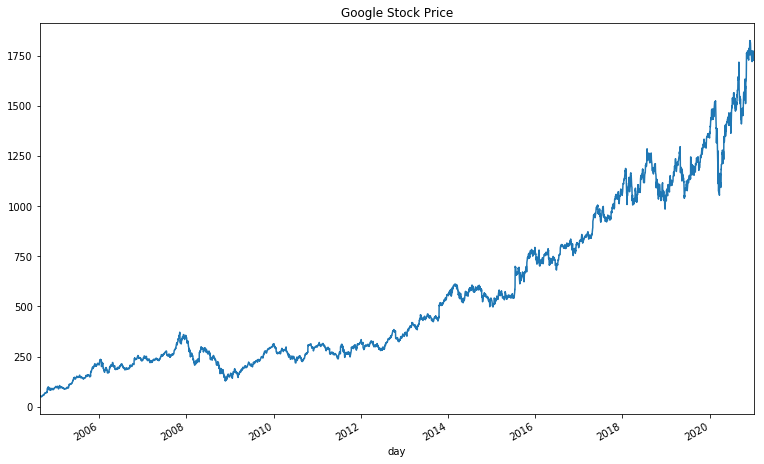

In [17]:
df_google['close'].plot(figsize=(8*1.6,8), title='Google Stock Price')
plt.show()

Here we resample to 1 week average values just for illustrative purpose

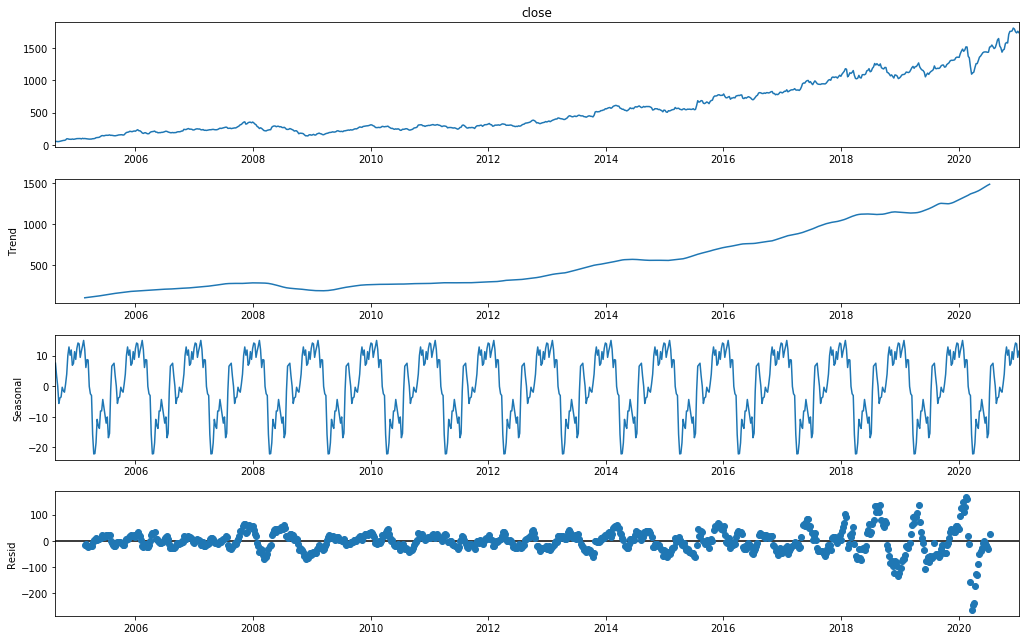

In [18]:
decompose_result = sm.tsa.seasonal_decompose(google_close.resample('1W').mean().dropna())
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    trend = decompose_result.trend
    seasonal = decompose_result.seasonal
    residual = decompose_result.resid
    decompose_result.plot();

*The time series is clearly `non-stationary`, so we need to transform to obtain (weak) stationarity.* 

We will be using `log-returns` as transformation:
$$
r_t = \log\frac{X_t}{X_{t-1}}
$$

In [19]:
google_rt = np.log(google_close.sort_index(ascending=True).divide(google_close.sort_index(ascending=True).shift(1))).sort_index(ascending=False)
google_rt = google_rt[~google_rt.isnull()][:300]

In [20]:
pd.DataFrame(pd.concat([google_close, google_rt], axis=1).reset_index().values, columns=['day', 'close', 'r_t']).set_index('day').sort_index(ascending=False).head()

close         r_t
day                            
2021-01-05  1740.05  0.00803197
2021-01-04  1726.13  -0.0152413
2020-12-31  1752.64  0.00939562
2020-12-30  1736.25  -0.0123127
2020-12-29  1757.76 -0.00917404

In [21]:
# individual return compuation for demonstration
np.log(1740.05/1726.13)

0.008031939964980766

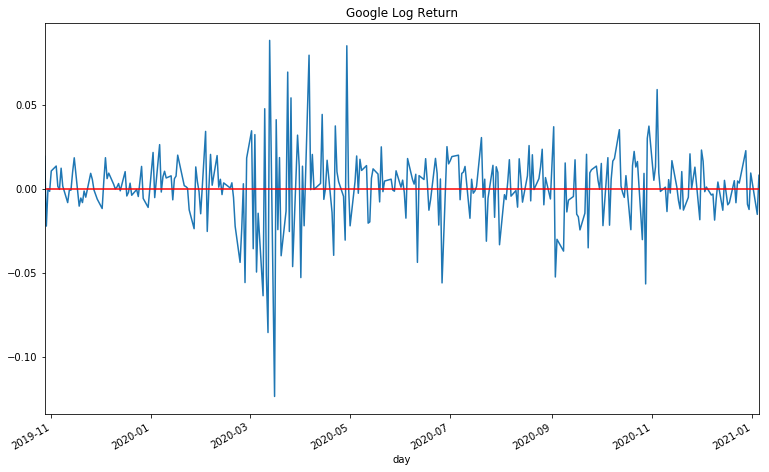

In [22]:
fig, ax = plt.subplots()
google_rt.plot(figsize=(8*1.6,8), title='Google Log Return', ax=ax)
x_vals = ax.get_xticks()
plt.axhline(0.0, color='r')
plt.show()

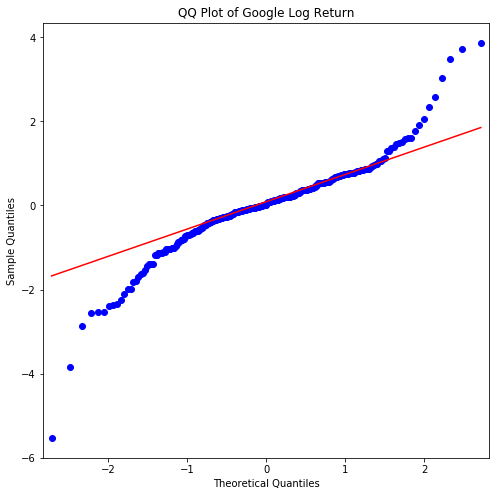

In [23]:
fig, ax = plt.subplots(figsize=(8,8))
sm.graphics.qqplot(google_rt, line='q', fit=True, ax=ax)
ax.set_title('QQ Plot of Google Log Return')
plt.show()

**Augmented Dickey-Fuller test**: null hypothesis $H_0$: a unit root is present in a time series sample $\Rightarrow$ non-stationary.

In [25]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [26]:
adf_test(google_rt)

Results of Dickey-Fuller Test:
Test Statistic                  -4.518137
p-value                          0.000182
#Lags Used                       8.000000
Number of Observations Used    291.000000
Critical Value (1%)             -3.453023
Critical Value (5%)             -2.871524
Critical Value (10%)            -2.572090
dtype: float64


*We see `p-value` is less then both 0.05 and 0.01 significance levels, hence we `reject` $H_0$ of unit root to be present in our return time series!*

# Training | (Validation) |  Testing splits

At this moment we will partition our data set in a series of training and testing sub-sets. We will be using training set to fit our model and testing set to compute the forecasting performance metrices.

In theory we can further partition training set into training and validation sub-sets, where we fit our model on training set, then use validation set to fine-tune the model parameters and only then compute forecasting performance metrices using test sub-set.

In [27]:
tscv = TimeSeriesSplit(n_splits=9) # given by scikit-learn

In [29]:
X = google_rt.sort_index(ascending=True)

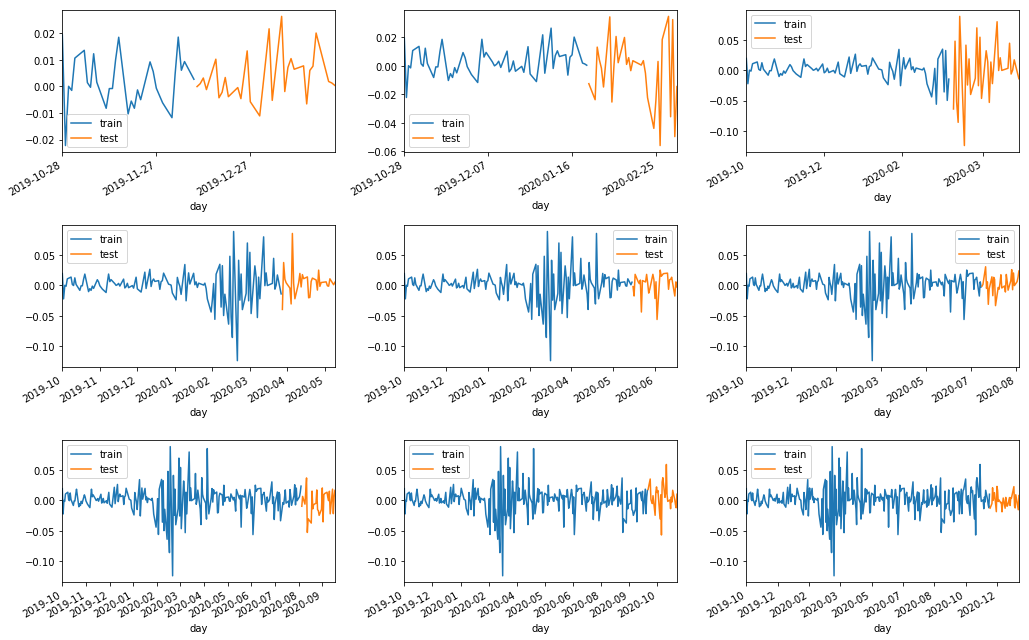

In [30]:
fig, axs = plt.subplots(3,3, figsize=(9*1.6,9))
i=j=0
splits=[]
for train_index, test_index in tscv.split(X):      
    X_train, X_test = X[train_index].resample('1D').mean(), X[test_index].resample('1D').mean()
    X_train.dropna().plot(ax=axs[i,j], label='train')
    X_test.dropna().plot(ax=axs[i,j], label='test')
    splits.append((X_train,X_test))
    idx  = pd.concat([X_train, X_test], axis=0).index
    axs[i,j].set_xticks(idx[0::(j+3)*10])
    axs[i,j].legend()        
    j+=1
    if j%3==0:
        i+=1
        j=0
plt.tight_layout()
plt.show()

# Modelling

At this moment we have generated 9 train/test splits. 

Below we will demonstrate the process of 
* calibrating the model
* forecasting
* computing performance metrics

for just `the last` (out of 9) X_train, X_test pairs.

Subsequently, this process will be repeteaded 9 times and the average of the performance metrics will become a `cross-validation error.`

**Sample Autocorrelation | Partial autocorrelation functions**

**ACF** is an (complete) auto-correlation function which gives us values of auto-correlation of any series with its lagged values. We plot these values along with the confidence. 

In simple terms, it describes how well the present value of the series is related with its past values. A time series can have components like trend, seasonality, cyclic and residual. ACF considers all these components while finding correlations hence it’s a ‘complete auto-correlation plot’.

**PACF** is a partial auto-correlation function. Basically instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as we remove already found variations before we find the next correlation. 

So if there is any hidden information in the residual which can be modeled by the next lag, we might get a good correlation and we will keep that next lag as a feature while modeling. Remember while modeling we don’t want to keep too many features which are correlated as that can create multicollinearity issues. Hence we need to retain only the relevant features.

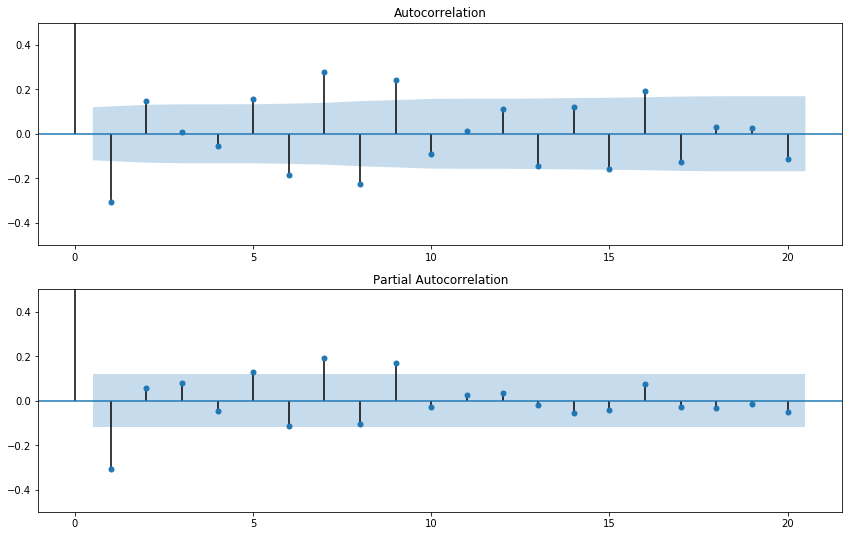

In [31]:
fig = plt.figure(figsize=(9*1.6,9))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(X_train.dropna(), lags=20, ax=ax1)
ax1.set_ylim(-0.5,0.5)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(X_train.dropna(), lags=20, ax=ax2, method='ols')
ax2.set_ylim(-0.5,0.5)
plt.show()

## AR(I)MA

**AR(p)** 
$$
y_t = c + \phi_1y_{t-1} + \phi_2y_{t-2}+\ldots+\phi_py_{t-p}+\varepsilon_t
$$

Here $\varepsilon_t$ is white noise (a collection of uncorrelated random variables, with mean $0$ and finite variance $\sigma^2$)

Order **p** is the lag value after which *PACF* plot crosses the upper confidence interval for the first time. 

These p lags will act as our features while forecasting the AR time series. We cannot use the ACF plot here because it will show good correlations even for the lags which are far in the past. If we consider those many features, we will have multicollinearity issues.This is not a problem with PACF plot as it removes components already explained by earlier lags, so we only get the lags which have the correlation with the residual i.e the component not explained by earlier lags.

**MA(q)**
$$
y_t = c + \varepsilon_t + \theta_1\varepsilon_{t-1}+\theta_2\varepsilon_{t-2}+\ldots+\theta_q\varepsilon_{t-q}
$$

Here $\varepsilon_t$ is white noise (a collection of uncorrelated random variables, with mean $0$ and finite variance $\sigma^2$)

Order **q** of the MA process is obtained from the *ACF* plot, this is the lag after which ACF crosses the upper confidence interval for the first time. 

As we know PACF captures correlations of residuals and the time series lags, we might get good correlations for nearest lags as well as for past lags. Why would that be? Since our series is linear combination of the residuals and none of time series own lag can directly explain its present (since its not an AR), which is the essence of PACF plot as it subtracts variations already explained by earlier lags, its kind of PACF losing its power here! On the other hand being a MA process, it doesn’t have the seasonal or trend components so the ACF plot will capture the correlations due residual components only. You can also think of it as ACF which is a complete plot (capturing trend, seasonality, cyclic and residual correlations) acting as a partial plot since we don’t have trends, seasons, etc.

### Model Summary

The theory tells to choose $p=5$ from PACF plot above and $q=2$ from ACF plot above, however for the model with $p=5$ all coefficients are not-significant. 

Hence we choose most parsimonious, simple model for demonstration. 

In [32]:
mod = sm.tsa.arima.ARIMA(endog=X_train, order=(2,0,2), trend='n', enforce_stationarity=True, freq='1D')
res = mod.fit(cov_type='robust')
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  389
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 650.365
Date:                Mon, 08 Feb 2021   AIC                          -1290.729
Time:                        15:55:55   BIC                          -1270.911
Sample:                    10-28-2019   HQIC                         -1282.873
                         - 11-19-2020                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8403      0.048    -38.620      0.000      -1.934      -1.747
ar.L2         -0.9327      0.050    -18.513      0.000      -1.031      -0.834
ma.L1          1.6653      0.098     17.074      0.0

**Ljung–Box** test $H_0$: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process)

**Jarque–Bera** test $H_0$: is a goodness-of-fit test of whether sample data have the skewness and kurtosis matching a normal distribution. A joint $H_0$ of the skewness being zero and the excess kurtosis being zero.

### Diagnostic Plots

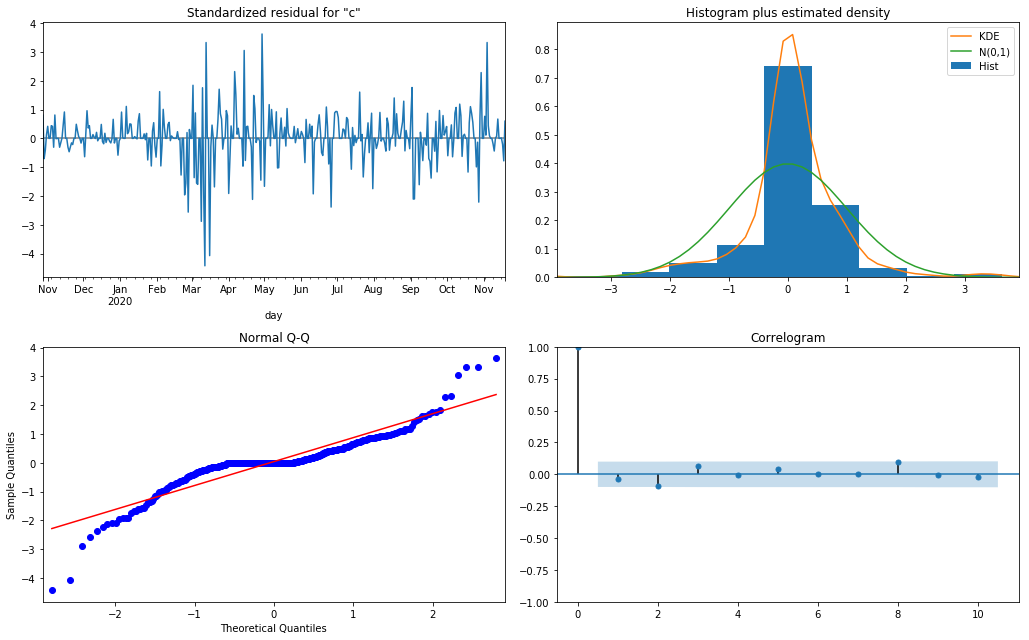

In [33]:
with mpl.rc_context():
    mpl.rc("figure", figsize=(9*1.6,9))
    res.plot_diagnostics()
    plt.tight_layout()

## Forecasting | Performance Metrics 

$$
\log \left(\dfrac{X_{t+1}}{X_{t}}\right) = \hat{r_{t+1}} \Rightarrow \hat{X_{t+1}} = X_{t}e^{\hat{r_{t+1}}}
$$



1 period forecasting:

In [34]:
# first time-tick for forecasting:
t = X_test.index[0]; t.date()

datetime.date(2020, 11, 20)

In [35]:
# forecast the next time-tick return:
r_t_plus_1 = res.forecast()[0]; r_t_plus_1

0.0011225121344680365

In [36]:
# true stock price:
true_X_t_plus_1 = google_close[t]; true_X_t_plus_1

1736.3800048828

In [37]:
# estimated stock price:
estim_X_t_plus_1 = google_close[t] * np.exp(r_t_plus_1);estim_X_t_plus_1

1738.3302068662474

multi-period forecasting:

In [38]:
# we concatenate the last known price with the forecasted returns:

forecast = pd.concat([
    pd.Series(google_close[X_train.index.max()], index=[X_train.index.max()]),
    res.predict(X_test.resample('1D').mean().index.min(), X_test.resample('1D').mean().index.max())
], axis=0)


# now using the log_return lambda function

log_return = lambda a,b: a*np.exp(b)

# we cacluate the multi-period stock price forecast

idx = X_test.index.append(pd.DatetimeIndex([X_train.index.max()])).sort_values()
forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], index=idx, columns=['forecast']); forecast.head()

forecast
2020-11-19  1758.569946
2020-11-20  1760.545071
2020-11-21  1756.985858
2020-11-22  1761.696129
2020-11-23  1756.349470

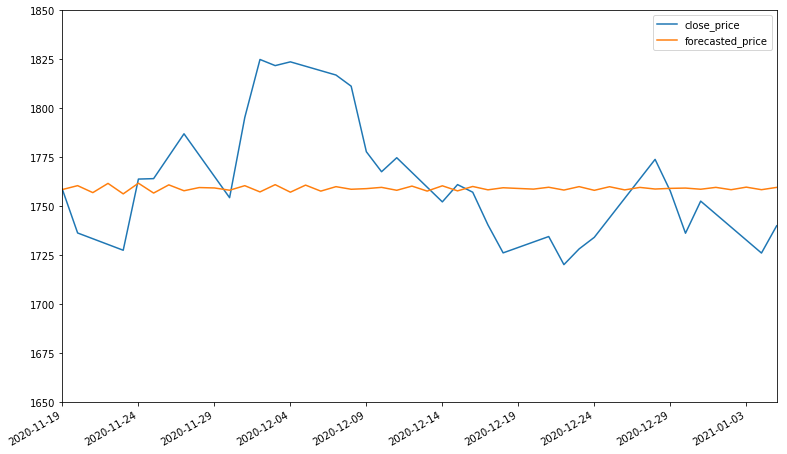

In [39]:
fig, ax = plt.subplots(figsize=(8*1.6, 8))
google_close.loc[forecast.index].dropna().plot(ax=ax)
forecast.dropna().plot(ax=ax)
idx  = forecast.index
ax.set_xticks(idx[0::5])
ax.legend(['close_price', 'forecasted_price'])
ax.set_ylim([1650, 1850])
plt.show()

**Metrics**

* Mean absolute error (MAE):
$$
    \dfrac{\sum^n_{t=1}|Actuals - Forecast|}{n}
$$
* Mean squared Error (MSE):
$$
    \dfrac{\sum^n_{t=1}(Actuals - Forecast)^2}{n}
$$

* Mean percentage error (MPE):
$$
\dfrac{100%}{n}\dfrac{\sum^n_{t=1}Actuals - Forecast}{Actuals}
$$
* Mean absolute percentage error (MAPE)
$$
\dfrac{100%}{n}\sum^n_{t=1} \left \lvert \dfrac{Actuals - Forecast}{Actuals}\right\rvert
$$

The first two are readily available in the `scikit-learn` module.

In [40]:
performance_df = forecast.join(google_close).dropna()

In [41]:
mae = mean_absolute_error(performance_df.close.values, performance_df.forecast.values)

In [42]:
mse = mean_squared_error(performance_df.close.values, performance_df.forecast.values)

In [43]:
def mean_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((y_true - y_pred) / y_true) * 100

In [44]:
mpe = mean_percentage_error(performance_df.close.values, performance_df.forecast.values)

In [45]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [46]:
mape = mean_absolute_percentage_error(performance_df.close.values, performance_df.forecast.values)

In [47]:
print(f'Performance metrics summary:\nMAE = {mae:.2f}\nMSE = {mse:.2f}\nMPE = {mpe:.2f}\nMAPE = {mape:.2f}')

Performance metrics summary:
MAE = 24.53
MSE = 979.72
MPE = 0.19
MAPE = 1.38


# Cross-Validation Error 

**Now repeating the above for all 9 splits we can compute the Cross-Validation error, choosing one particular metric as representative one: `MAPE`**

In [48]:
av_score = []
for i, split in enumerate(splits):
    X_train= split[0]
    X_test = split[1]

    mod = sm.tsa.arima.ARIMA(endog=X_train, order=(2,0,2), trend='n', enforce_stationarity=True, freq='1D')
    res = mod.fit(cov_type='robust')

    # we concatenate the last known price with the forecasted returns:

    forecast = pd.concat([
        pd.Series(google_close[X_train.index.max()], index=[X_train.index.max()]),
        res.predict(X_test.resample('1D').mean().index.min(), X_test.resample('1D').mean().index.max())
    ], axis=0)

    # now using the log_return lambda function

    log_return = lambda a,b: a*np.exp(b)

    # we cacluate the multi-period stock price forecast

    idx = X_test.index.append(pd.DatetimeIndex([X_train.index.max()])).sort_values()
    forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], index=idx, columns=['forecast']); forecast.head()

    performance_df = forecast.join(google_close).dropna()

    mae = mean_absolute_error(performance_df.close.values, performance_df.forecast.values)

    mse = mean_squared_error(performance_df.close.values, performance_df.forecast.values)

    mpe = mean_percentage_error(performance_df.close.values, performance_df.forecast.values)

    mape = mean_absolute_percentage_error(performance_df.close.values, performance_df.forecast.values)

    av_score.append(mape)

    print(f'Fold={i+1}\nPerformance metrics summary:\nMAE = {mae:.2f}\nMSE = {mse:.2f}\nMPE = {mpe:.2f}\nMAPE = {mape:.2f}\n')

print(f'Cross Validation MAPE: {np.mean(av_score):.2f}% +/- {np.std(av_score):.2f}% ')

Fold=1
Performance metrics summary:
MAE = 51.14
MSE = 5034.04
MPE = 3.56
MAPE = 3.56

Fold=2
Performance metrics summary:
MAE = 59.52
MSE = 6431.77
MPE = -3.23
MAPE = 4.31

Fold=3
Performance metrics summary:
MAE = 129.50
MSE = 21762.02
MPE = -11.47
MAPE = 11.47

Fold=4
Performance metrics summary:
MAE = 73.79
MSE = 7230.90
MPE = 4.47
MAPE = 5.34

Fold=5
Performance metrics summary:
MAE = 30.43
MSE = 1509.57
MPE = -0.51
MAPE = 2.10

Fold=6
Performance metrics summary:
MAE = 29.92
MSE = 1671.33
MPE = 0.62
MAPE = 1.93

Fold=7
Performance metrics summary:
MAE = 124.48
MSE = 20373.41
MPE = -8.07
MAPE = 8.44

Fold=8
Performance metrics summary:
MAE = 164.34
MSE = 36231.54
MPE = 9.70
MAPE = 9.70

Fold=9
Performance metrics summary:
MAE = 24.53
MSE = 979.72
MPE = 0.19
MAPE = 1.38

Cross Validation MAPE: 5.36% +/- 3.47% 


# Final Model

In [49]:
mod = sm.tsa.arima.ARIMA(endog=google_rt.resample('1D').mean(), order=(2,0,2), trend='n', enforce_stationarity=True, freq='1D')
res = mod.fit(cov_type='robust')
print(res.summary())
# we concatenate the last known price with the forecasted returns:

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  436
Model:                 ARIMA(2, 0, 2)   Log Likelihood                 731.324
Date:                Mon, 08 Feb 2021   AIC                          -1452.648
Time:                        15:57:24   BIC                          -1432.260
Sample:                    10-28-2019   HQIC                         -1444.602
                         - 01-05-2021                                         
Covariance Type:               robust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8196      0.033    -54.424      0.000      -1.885      -1.754
ar.L2         -0.9536      0.030    -32.191      0.000      -1.012      -0.896
ma.L1          1.7535      0.037     47.890      0.0

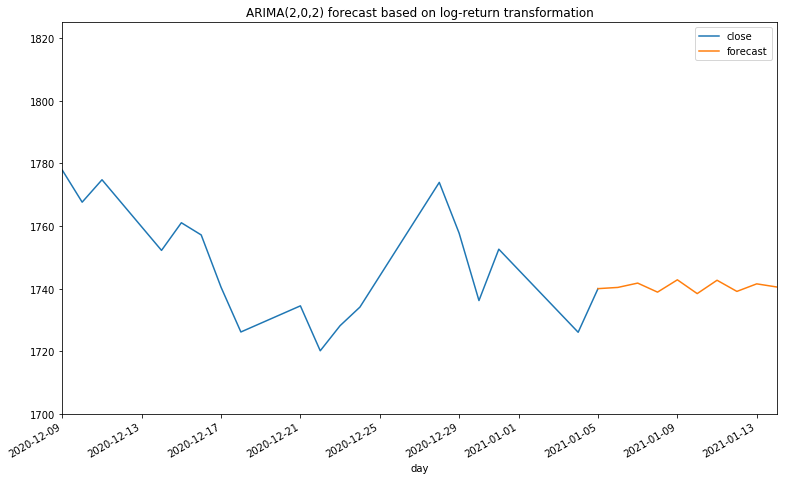

In [50]:
forecast = pd.concat([
    pd.Series(google_close[google_rt.index.max()], index=[google_rt.index.max()]),
    res.predict((google_rt.index.max()+pd.DateOffset(days=1)).date(), 
                pd.date_range(start=google_rt.index.max(), periods=10, freq='1D' ).max().date())
], axis=0)

# now using the log_return lambda function

log_return = lambda a,b: a*np.exp(b)

# we cacluate the multi-period stock price forecast

idx = pd.date_range(start=google_rt.index.max(), periods=10, freq='1D' )
forecast = pd.DataFrame([*itertools.accumulate(forecast.values,log_return)], index=idx, columns=['forecast']); forecast.head()

fig, ax = plt.subplots(figsize=(8*1.6, 8))
google_close[google_close.index>pd.to_datetime(date(2020,12,8))].plot(ax=ax)
forecast.plot(ax=ax)
ax.legend()
ax.set_ylim([1700, 1825])
ax.set_title('ARIMA(2,0,2) forecast based on log-return transformation')
plt.show()